In [21]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel, BiphasicAxonMapSpatial, Nanduri2012Model, Nanduri2012Temporal, AxonMapSpatial, Model
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
from pulse2percept.stimuli import BiphasicPulseTrain, Stimulus
from pulse2percept.viz import scatter_correlation
from pulse2percept.datasets import load_nanduri2012
import shapes

import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import random
import math

# General

### Caculate regionprops 

In [2]:
data = shapes.load_shapes("../data/shapes.h5", stim_class='SingleElectrode', subjects=['12-005', '51-009', '52-001'])
data.head()

,subject,amp1,amp2,area,compactness,date,eccentricity,elec_delay,electrode1,electrode2,...,image,implant,num_regions,orientation,pdur,stim_class,trial,x_center,y_center,img_shape
0,12-005,1.5,0.0,145,0.188493,20091028,0.936365,0.0,A2,,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.682111,0.45,SingleElectrode,9,102.857140,147.142853,"(384, 512)"
1,12-005,1.5,0.0,174,0.165999,20091028,0.968756,0.0,A2,,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.324369,0.45,SingleElectrode,17,129.333328,160.666672,"(384, 512)"
2,12-005,1.5,0.0,142,0.173824,20091028,0.871929,0.0,A2,,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.594180,0.45,SingleElectrode,30,151.000000,199.000000,"(384, 512)"
3,12-005,1.5,0.0,137,0.192119,20091028,0.925959,0.0,A2,,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.281614,0.45,SingleElectrode,38,256.000000,192.000000,"(384, 512)"
4,12-005,1.5,0.0,133,0.217631,20091028,0.992635,0.0,A2,,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.609992,0.45,SingleElectrode,51,140.000000,218.000000,"(384, 512)"


In [3]:
len(data)

1817

In [4]:
def get_prop(row):
    props = measure.regionprops(measure.label(row.image), cache=True)
    return max(props, key = lambda x: x.area)
data['prop'] = data.apply(get_prop, axis=1)
data['area'] = data.apply(lambda x : x.prop.area, axis=1)
data['major'] = data.apply(lambda x : x.prop.major_axis_length, axis=1)
data['minor'] = data.apply(lambda x : x.prop.minor_axis_length, axis=1)
data['eccentricity'] = data.apply(lambda x : x.prop.eccentricity, axis=1)
data['streak'] = data.apply(lambda x : x.prop.major_axis_length - x.prop.minor_axis_length, axis=1)

In [5]:
df = data.groupby(['subject', 'amp1', 'freq', 'pdur', 'electrode1'])[['area', 'major', 'minor', 'eccentricity', 'streak']].mean().reset_index()
df.head()

,subject,amp1,freq,pdur,electrode1,area,major,minor,eccentricity,streak
0,12-005,1.25,20.0,0.45,A1,531.6,80.319766,13.211998,0.975764,67.107767
1,12-005,1.25,20.0,0.45,A4,922.6,39.846916,31.256068,0.597529,8.590848
2,12-005,1.25,20.0,0.45,A8,668.9,44.628947,19.959686,0.865677,24.669261
3,12-005,1.25,20.0,0.45,B1,729.8,68.859026,21.308238,0.918401,47.550788
4,12-005,1.25,20.0,0.45,B3,653.6,41.400322,21.819501,0.800876,19.580821


### Get model predictions and props

In [26]:
def get_prop(percept, thresh=None):
    frame = percept.max(axis='frames')
    if thresh is None:
        thresh = (frame.max() - frame.min()) * 0.1 + frame.min()
    props = measure.regionprops(measure.label(frame > thresh))
    return max(props, key = lambda x: x.area)

In [80]:
# old effects models
class DefaultBrightModel(): 
    # F_{bright}
    def __init__(self,  do_thresholding=True):
        self.amp_freq_model = LinearRegression()
        self.do_thresholding = do_thresholding

    # Not used in notebook
    def fit(self):
        self._fit_amp_freq()

    # Not used in notebook
    def _fit_amp_freq(self):
        # hard coded to linear regression parameters for now
        pass

    def predict_pdur(self, pdur): 
        # Based on eq 3 in paper, this function produces the factor that amplitude will be scaled by to produce a_tilde  
        # Computes (A_0 * t + A_1)^-1
        # Fit using color threshold of weitz et al 2015
        return 1 / (0.8825 + 0.27*pdur)
       
    def predict_freq_amp(self, scaled_amp, freq): 
        # Eq 4 in paper, A_2*A_tilde + A_3*f + A_4
        return 1.84*scaled_amp + 0.2*freq + 3.0986

    def __call__(self, amp, freq, pdur):
        
        # Scale amp according to pdur (Eq 3 in paper) and then calculate F_{bright}
        F_bright = self.predict_freq_amp(amp * self.predict_pdur(pdur), freq) 
        
        # If thresholding is enabled, phosphene only has a chance of appearing, determined by this sigmoid
        # p = -1/96 + 97 / (96(1+96 exp(-ln(98)amp)))
        # Sigmoid with p[0] = 0, p[1] = 0.5, p[2] = 0.99
        p = -0.01041666666667 + 1.0104166666666667 / (1+96 * np.exp(-4.584967478670572 * amp * self.predict_pdur(pdur)))
        if not self.do_thresholding or np.random.random() < p:
            return F_bright
        else:
            return 0


class DefaultSizeModel():
    # F_{size}
    def __init__(self, rho):
        self.amp_model = LinearRegression()
        self.min_rho = 10 # dont let rho be scaled below this threshold
        self.min_scale = self.min_rho**2 / rho**2
    def fit(self):
        self._fit_amp()

    def _fit_amp(self):
        # This fits Eq 5 in the paper to nanduri et al 2012 data
        # Linear regression with one predictor variable, A_5*A_tilde + A_6
        data = load_nanduri2012()
        data = data[data['task'] == 'size']
        x = data['amp_factor']
        y = data['size']
        self.amp_model.fit(np.array(x).reshape(-1, 1), y)
    
    def predict_pdur(self, pdur):
        # Based on eq 3 in paper, this function produces the factor that amplitude will be scaled by to produce a_tilde  
        # Computes (A_0 * t + A_1)^-1
        # Fit using color threshold of weitz et al 2015
        return 1 / (0.8825 + 0.27*pdur)

    def __call__(self, amp, freq, pdur):
        # Eq 5 in paper
        # Scale amp to get a_tilde, then use the linear regression equations (A_5*A_tilde + A_6) to produce F_size
        
        F_size = self.amp_model.predict(np.array([amp * self.predict_pdur(pdur)]).reshape(1, -1))[0] 
        if F_size > self.min_scale:
            return F_size
        else:
            return self.min_scale


class DefaultStreakModel():
    # F_{streak}
    def __init__(self, axlambda):
        # never decrease lambda to less than 10
        self.min_lambda = 10
        self.min_scale = self.min_lambda**2 / axlambda **2
    def __call__(self, amp, freq, pdur):
        # Fit using streak lengths measure from weitz et al 2015
        # Eq 6 from the paper, F_streak = -A_7 * t^A_8 + A_9
        F_streak = 1.56 - 0.54 * pdur ** 0.21
        if F_streak > self.min_scale:
            return F_streak
        else:
            return self.min_scale

In [147]:
### unnormalized,
m1 = Nanduri2012Model()
m1.build()

axon_map_models = {}
biphasic_models = {}
implants = {}

for subject in ['12-005', '51-009', '52-001']:
    implant, m3 = shapes.model_from_params(shapes.subject_params[subject])
    implant, m2 = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
    m2.rho = 117
    m3.rho = 117
    m2.axlambda = 900 
    m3.axlambda = 900
    m2.build()
    m3.build()
    axon_map_models[subject] = m2
    biphasic_models[subject] = m3
    implants[subject] = implant

props = []
for row in df.itertuples():
#     print(row)
    
    implant = implants[row.subject]
    m2 = axon_map_models[row.subject]
    m3 = biphasic_models[row.subject]
    
    ref_stim = {row.electrode1 : BiphasicPulseTrain(20, 1.25, row.pdur, stim_dur=50)}
    implant.stim = ref_stim
    ref_p2 = m2.predict_percept(implant)
    ref_p3 = m3.predict_percept(implant)
    implant.stim = {row.electrode1 : BiphasicPulseTrain(20, 30 * 1.25, row.pdur, stim_dur=500)}
    ref_p1 = m1.predict_percept(implant)
    
    
    stim = {row.electrode1 : BiphasicPulseTrain(row.freq, row.amp1, row.pdur, stim_dur=50)}
#     print(row.amp1)
    implant.stim = stim
    p2 = m2.predict_percept(implant)
    p3 = m3.predict_percept(implant)
#     p3.plot()
#     plt.show()
    # multiply by 30; nanduri takes raw amplitudes
    implant.stim = {row.electrode1 : BiphasicPulseTrain(row.freq, 30 * row.amp1, row.pdur, stim_dur=500)}
    p1 = m1.predict_percept(implant)
    
    props.append([get_prop(p) for p in [ref_p1, ref_p2, ref_p3, p1, p2, p3]])
#     print(props[-1][2].area)
#     print(props[-1][-1].area)
df[['ref_nanduri', 'ref_axonmap', 'ref_biphasic', 'nanduri', 'axonmap', 'biphasic']] = props

In [148]:
len(df)

178

In [149]:
ref_area = {}
ref_streak = {}
for subject in ['12-005', '51-009', '52-001']:
    ref_area[subject] = {}
    ref_streak[subject] = {}
    for elec in df[df['subject'] == subject].electrode1.unique():
        d = df[(df['subject'] == subject)]
        lr = LinearRegression()
        lr.fit(np.array(d['amp1']).reshape((-1, 1)), d['area'])
        ref_area[subject][elec] = lr.predict(np.array(1.25).reshape(1, 1))
        
        lr = LinearRegression()
        lr.fit(np.array(d['amp1']).reshape((-1, 1)), d['streak'])
        ref_streak[subject][elec] = lr.predict(np.array(1.25).reshape(1, 1))
        
df['ref_area'] = df.apply(lambda row : ref_area[row.subject][row.electrode1], axis=1)
df['ref_streak'] = df.apply(lambda row : ref_streak[row.subject][row.electrode1], axis=1)

12-005
nanduri area r2: -2.5381355046603438, streak r2: -28.59587296495162
axonmap area r2: -0.055890645183250154, streak r2: -0.033134702223887036
biphasic area r2: -0.7349208995814795, streak r2: -0.09878071159942059

51-009
nanduri area r2: -7.768334561864982, streak r2: -467.2925462095182
axonmap area r2: -0.003957844258732024, streak r2: -0.001514577651106963
biphasic area r2: -3.989953208841883, streak r2: -0.7561163243819458

52-001
nanduri area r2: -1.185522663756545, streak r2: -1.327404450085424
axonmap area r2: -1.1110369064659062, streak r2: -0.005146550195297639
biphasic area r2: -1.1907382048204913, streak r2: -0.15272826099776138



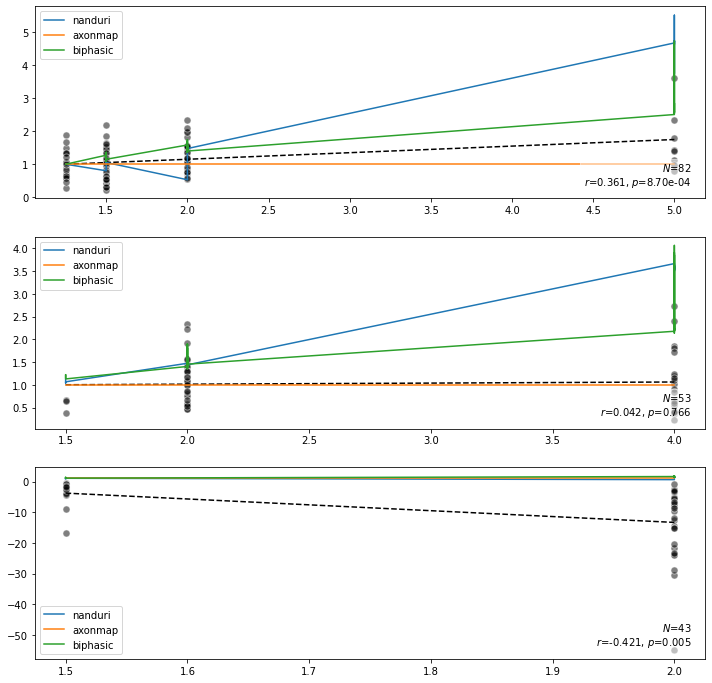

In [150]:
fig, axes = plt.subplots(3, figsize=(12, 12))
for i, subject in enumerate(['12-005', '51-009', '52-001']):
    ax = axes[i]
    d = df[df['subject'] == subject]
    print(subject)
    scatter_correlation(np.array(d['amp1'], dtype='float32'), np.array(d['area'] / d['ref_area'], dtype='float32'), ax=ax)
    for model in ['nanduri', 'axonmap', 'biphasic']:
        areas = np.array([p.area for p in d[model]]) / np.array([p.area for p in d["ref_" + model]])
        streaks = np.array([p.major_axis_length - p.minor_axis_length for p in d[model]]) / np.array([p.major_axis_length - p.minor_axis_length for p in d["ref_" + model]])
        
        ax.plot(d['amp1'], areas, label=model)
        r2_area = r2_score(d['area'] / d['ref_area'], areas)
        r2_streaks = r2_score(d['streak'] / d['ref_streak'], streaks)
        
        print(f"{model} area r2: {r2_area}, streak r2: {r2_streaks}")
    ax.legend()
    print()

In [119]:
np.sum(np.array([p for p in df['biphasic']]) == np.array([p for p in df['ref_biphasic']]))

178

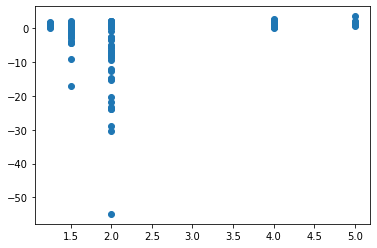

In [95]:
# plt.scatter(df['amp1'], df['area'])
plt.scatter(df['amp1'], df['area'] / df['ref_area'])

In [96]:
df['ref_area']

0      [491.21747586934003]
1      [491.21747586934003]
2      [491.21747586934003]
3      [491.21747586934003]
4      [491.21747586934003]
               ...         
173     [-115.305604864217]
174     [-115.305604864217]
175     [-115.305604864217]
176     [-115.305604864217]
177     [-115.305604864217]
Name: ref_area, Length: 178, dtype: object

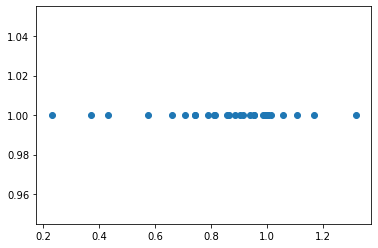

In [86]:
plt.scatter(d['streak'] / d['ref_streak'], streaks)

In [160]:
s = df[df['subject'] == '12-005']

<AxesSubplot:xlabel='amp1', ylabel='area'>

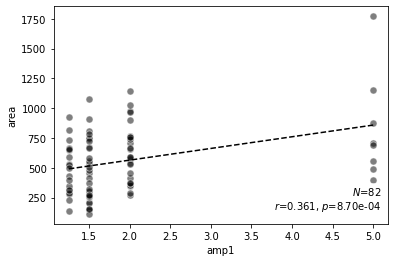

In [161]:
scatter_correlation(s['amp1'], s['area'])

# Patient Specific

In [37]:
def get_prop(frame, thresh=None):
    if thresh is None:
        thresh = (frame.max() - frame.min()) * 0.1 + frame.min()
    props = measure.regionprops(measure.label(frame > thresh))
    return max(props, key = lambda x: x.area)

train_size = 0.75
fits = {}
for subject in ['12-005', '51-009', '52-001']:
    print(subject)
    fits[subject] = {}
    sub_data = data[data.subject == subject]
    electrodes = sub_data.electrode1.unique()
    train_elecs = random.sample(list(electrodes), math.ceil(train_size * len(electrodes)))
    test_elecs = [i for i in electrodes if i not in train_elecs]
    train_data = sub_data[sub_data.electrode1.isin(train_elecs)]
    test_data = sub_data[sub_data.electrode1.isin(test_elecs)]
    print(f"Training on {train_elecs} and testing on {test_elecs}")
    
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=True)
    model.build()
    model.xystep=0.5
    
    mse_params=['area', "major_axis_length", "minor_axis_length"]
    estimator1 = shapes.BiphasicAxonMapEstimator(implant=implant, model=model, resize=True, loss_fn='r2', scale_features=False, mse_params=mse_params)
    search_params1 = {
        'rho': (10, 500),
        'axlambda': (10, 2000)
    }
    opt1 = ParticleSwarmOptimizer(estimator1, search_params1, max_iter=50, swarm_size=25, has_loss_function=True)
    
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
    model.build()
    model.xystep=0.5
    estimator2 = shapes.AxonMapEstimator(implant=implant, model=model, resize=True, mse_params=mse_params, loss_fn='r2', scale_features=False)
    search_params2 = {
        'rho': (10, 1000),
        'axlambda': (10, 2000)
    }
    opt2 = ParticleSwarmOptimizer(estimator2, search_params2, max_iter=30, swarm_size=20, has_loss_function=True)
    
    model = Model(spatial=AxonMapSpatial(), temporal=Nanduri2012Temporal())
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False, model=model)
    model.xystep=0.5
    model.dt=0.1
    estimator3 = shapes.NanduriAxonMapEstimator(implant=implant, model=model, mse_params=mse_params, loss_fn='r2', scale_features=False, resize=True)
    search_params3 = {
        'rho': (10, 500),
        'axlambda': (10, 2000),
        'tau1' : (0, 1.25),
        'tau2' : (20, 90),
        'tau3' : (10, 50),
        'slope' : (1.5, 6),
        'shift' : (8, 32)
    }

    opt3 = ParticleSwarmOptimizer(estimator3, search_params3, max_iter=50, swarm_size=50, has_loss_function=True)
    
    x = train_data[['amp1', 'freq', 'pdur', 'electrode1']]
    y = train_data['image']
    for estimator, opt, name, search_params in zip( [estimator1, estimator2], [opt1, opt2], ['biphasic', 'axonmap'], [search_params1, search_params2]):
        print(name)
        fits[subject][name] = {}
        y_moments = estimator.compute_moments(y)
        # fit size model
        if name == 'biphasic':
            estimator.fit_size_model(x['amp1'], y)
        y_moments = estimator.compute_moments(y)
        train_data[mse_params] = y_moments
        averaged_moments = train_data.groupby(['amp1', 'freq', 'pdur', 'electrode1'])[mse_params].mean()
        x = train_data[['amp1', 'freq', 'pdur', 'electrode1']].drop_duplicates()
        # fit rest of model

        estimator.score(x, averaged_moments)
        opt.fit(x, averaged_moments)
        train_score = estimator.score(x, averaged_moments)

        

        pred_props = [get_prop(p) for p in estimator.predict(x)]
        pred_areas = np.array([p.area for p in pred_props])
        pred_streaks = np.array([p.major_axis_length - p.minor_axis_length for p in pred_props])

        train_area_r2 = r2_score(averaged_moments['area'], pred_areas)
        train_streak_r2 = r2_score(averaged_moments['major_axis_length'] - averaged_moments['minor_axis_length'], pred_streaks)


        test_y = test_data['image']
        test_y_moments = estimator.compute_moments(test_y)
        test_data[mse_params] = test_y_moments
        test_averaged_moments = test_data.groupby(['amp1', 'freq', 'pdur', 'electrode1'])[mse_params].mean()
        test_x = test_data[['amp1', 'freq', 'pdur', 'electrode1']].drop_duplicates()
        
        test_score = estimator.score(test_x, test_averaged_moments)

        pred_props = [get_prop(p) for p in estimator.predict(test_x)]
        pred_areas = np.array([p.area for p in pred_props])
        pred_streaks = np.array([p.major_axis_length - p.minor_axis_length for p in pred_props])

        test_area_r2 = r2_score(test_averaged_moments["area"], pred_areas)
        test_streak_r2 = r2_score(test_averaged_moments['major_axis_length'] - test_averaged_moments['minor_axis_length'], pred_streaks)

        if name == 'biphasic':
            fits[subject][name]['a5'] = estimator.a5
        for param in search_params:
            fits[subject][name][param] = getattr(estimator, param)
        
        fits[subject][name]["train_r2_area"] = train_area_r2
        fits[subject][name]["train_r2_streak"] = train_streak_r2
        fits[subject][name]["test_r2_area"] = test_area_r2
        fits[subject][name]["test_r2_streak"] = test_streak_r2
        fits[subject][name]['train_log_error'] = train_score
        fits[subject][name]['test_log_error'] = test_score
    
        print(fits[subject])
        print()
    print("===================================")

    
    

12-005
Training on ['E3', 'C1', 'C10', 'E7', 'D1', 'B1', 'A2', 'B3', 'C7', 'B9', 'D6', 'E9', 'E10', 'A4', 'D8', 'A10', 'F9', 'F2', 'D4', 'D10', 'E1', 'C8', 'A6'] and testing on ['F7', 'A1', 'A8', 'D7', 'F4', 'F6', 'C4']
biphasic
a5=0.186878, a6=0.626244
score:8.953, rho:200.0, lambda:500.0, a5:0.187, empty:0, scores: ['area:4.9', 'major_axis_length:1.1', 'minor_axis_length:2.9']
score:241.288, rho:474.9, lambda:769.6, a5:0.187, empty:0, scores: ['area:197.3', 'major_axis_length:3.6', 'minor_axis_length:40.4']
score:13.655, rho:288.4, lambda:16.6, a5:0.187, empty:0, scores: ['area:5.3', 'major_axis_length:1.5', 'minor_axis_length:6.8']
score:127.755, rho:469.6, lambda:97.1, a5:0.187, empty:0, scores: ['area:89.3', 'major_axis_length:1.2', 'minor_axis_length:37.2']
score:11.266, rho:26.6, lambda:135.1, a5:0.187, empty:0, scores: ['area:3.7', 'major_axis_length:4.7', 'minor_axis_length:2.9']
score:7.419, rho:51.7, lambda:1443.3, a5:0.187, empty:0, scores: ['area:1.6', 'major_axis_length:4

In [38]:
fits

{'12-005': {'biphasic': {'a5': 0.18687819,
   'rho': 113.1711549596612,
   'axlambda': 540.6333465821739,
   'train_r2_area': -0.1975107500590345,
   'train_r2_streak': -0.21167347047132656,
   'test_r2_area': -0.9252216029753257,
   'test_r2_streak': -1.2297396769983768,
   'train_log_error': 3.603721589188911,
   'test_log_error': 7.243403754818008},
  'axonmap': {'rho': 98.79426419001268,
   'axlambda': 527.3242425195514,
   'train_r2_area': -0.07672269522016917,
   'train_r2_streak': -0.21800682385855086,
   'test_r2_area': -1.1918780393585444,
   'test_r2_streak': -1.2252104120958314,
   'train_log_error': 3.6095171839989537,
   'test_log_error': 8.04081073928237}},
 '51-009': {'biphasic': {'a5': -0.07911784,
   'rho': 25.797175060979004,
   'axlambda': 506.47648796219914,
   'train_r2_area': -0.20126430206057244,
   'train_r2_streak': -1.3206568864700015,
   'test_r2_area': -0.04177668678469204,
   'test_r2_streak': -0.8652467337047116,
   'train_log_error': 5.278551900017696,
  

In [39]:
data.freq.unique()

array([20.], dtype=float32)

<AxesSubplot:>

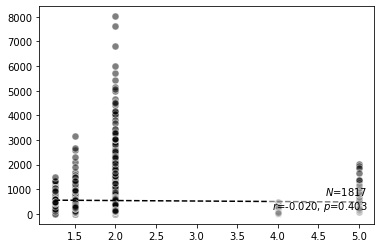

In [42]:
scatter_correlation(np.array(data.amp1), np.array(data['area']))

<AxesSubplot:>

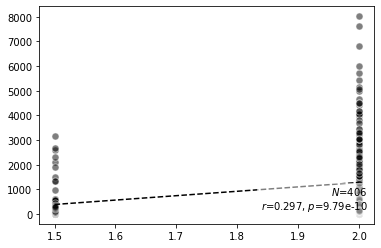

In [45]:
df = data[data.subject == '52-001']
scatter_correlation(np.array(df.amp1), np.array(df['area']))